In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent
from rl_equation_solver.utilities.utilities import build_adjacency_matrix
from rl_equation_solver.agent.networks import GCN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
from rex import init_logger
import torch
from torch_geometric.nn import GCNConv
from torch_geometric import utils
import scipy.sparse as sp
from sklearn.decomposition import PCA

In [20]:
init_logger(__name__, log_level='DEBUG')
init_logger('rl_equation_solver', log_level="DEBUG")

<Logger rl_equation_solver (DEBUG)>

In [21]:
def make_plot(agent, round):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    avg_loss = []
    avg_reward = []
    for episode in list(agent.history.keys()):
        avg_loss.append(np.mean(agent.history[episode]['loss']))
        avg_reward.append(np.mean(agent.history[episode]['reward']))
    
    
    y = moving_avg(avg_loss, 1)
    x = np.arange(len(y))
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(x, a*x+b, color='red')
    y = moving_avg(avg_reward, 1)
    a, b = np.polyfit(x, y, 1)
    ax[1].scatter(x, y)
    ax[1].plot(x, a*x+b, color='red')
    
    ax[0].set_title('Loss')
    ax[1].set_title("Reward")
    plt.annotate('Episode', (0.4, 0.01), xycoords='figure fraction')
    fig.suptitle(f'Round {round}')
    fig.savefig(f'./figs/round_{round}.png', dpi=300)

In [22]:
def moving_avg(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [23]:
env = Env(order=2)

In [24]:
agent = AgentGCN(env)

INFO - 2023-04-09 21:00:37,828 [gcn.py:40] : Initialized Agent with device cpu


In [25]:

for i in range(1):
    agent.train(num_episodes=5)
    make_plot(agent, round=i)    

INFO - 2023-04-09 21:00:38,779 [base.py:186] : episode 0, {'loss': 13, 'reward': '7.143e-02', 'state': 1 - a0}
INFO - 2023-04-09 21:00:38,833 [base.py:186] : episode 0, {'loss': 21, 'reward': '4.545e-02', 'state': (1 - a0)**a1}
INFO - 2023-04-09 21:00:38,890 [base.py:186] : episode 0, {'loss': 25, 'reward': '3.846e-02', 'state': ((1 - a0)**a1)**a1}
INFO - 2023-04-09 21:00:38,946 [base.py:186] : episode 0, {'loss': 29, 'reward': '3.333e-02', 'state': (((1 - a0)**a1)**a1)**a1}
INFO - 2023-04-09 21:00:39,000 [base.py:186] : episode 0, {'loss': 31, 'reward': '3.125e-02', 'state': (((1 - a0)**a1)**a1)**a1 + 1}
INFO - 2023-04-09 21:00:39,057 [base.py:186] : episode 0, {'loss': 31, 'reward': '3.125e-02', 'state': (((1 - a0)**a1)**a1)**a1 + 1}
INFO - 2023-04-09 21:00:39,108 [base.py:186] : episode 0, {'loss': 31, 'reward': '3.125e-02', 'state': (((1 - a0)**a1)**a1)**a1 + 1}
INFO - 2023-04-09 21:00:39,177 [base.py:186] : episode 0, {'loss': 41, 'reward': '2.381e-02', 'state': -a1 + (((1 - a0)**

TypeError: expected Tensor as element 0 in argument 0, but got GraphEmbedding

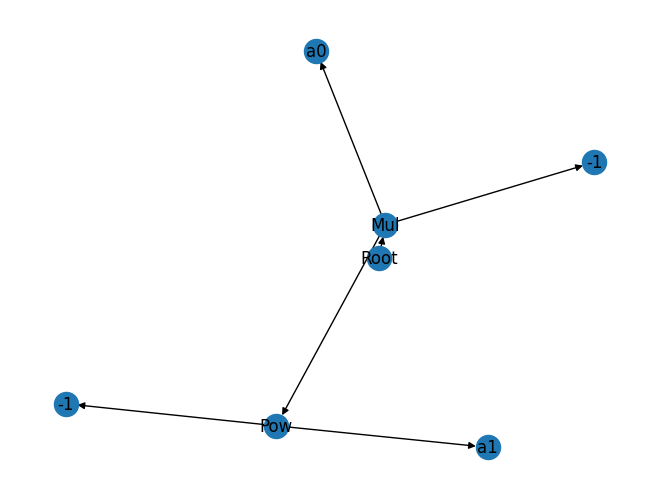

In [10]:
nx.draw(env.state_graph, labels=env.node_labels)